<a href="https://colab.research.google.com/github/Panos277/ProjectsMS/blob/master/MCDropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision pytorch-lightning optuna



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Change path direction

In [ ]:
cd drive/My Drive/mcdropout_msc

/content/drive/My Drive/mcdropout_msc


In [ ]:
import optuna 
import os
import pytorch_lightning as pl
import logging.config
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

from optuna.integration import PyTorchLightningPruningCallback
from torch.utils.data import DataLoader, random_split,TensorDataset
from sklearn.model_selection import train_test_split
from scipy.ndimage.interpolation import rotate
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import accuracy_score
from scipy.stats import entropy

from dataload import DataLoader as DL2
from dataload import MyDataset,ImageLoader
from nns import LeNet, LitModule, BNNRegressor
from utils import MetricsCallback,predict_mc


MODEL_DIR = "./model_dir/"

Defining loss functions

In [ ]:
#regression loss
# loss = nn.MSELoss(reduction='mean')
#classification loss
# loss = nn.CrossEntropyLoss()
loss = nn.NLLLoss()

**Load Dataset for regression**

In [ ]:
# dl = DL2(dataset='concrete')
# X, y = dl.return_data()
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=123,shuffle=True)

# X_train_ , X_val, y_train_, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=123,shuffle=True)

# y_train_ = y_train_.reshape((y_train_.shape[0],1))
# y_val = y_val.reshape((y_val.shape[0],1))
# y_test = y_test.reshape((y_test.shape[0],1))


# train_dataset = TensorDataset(torch.tensor(X_train_).float(),torch.tensor(y_train_).float())
# val_dataset = TensorDataset(torch.tensor(X_val).float(),torch.tensor(y_val).float())
# test_dataset = TensorDataset(torch.tensor(X_test).float(),torch.tensor(y_test).float())

# train_dataloader = DataLoader(train_dataset,batch_size=16)
# val_dataloader = DataLoader(val_dataset,batch_size=16)

**Load dataset for classification**

In [ ]:
transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(
                                          (0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='datasets/MNIST', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='datasets/MNIST', train=False, transform=transform)

val, test = torch.utils.data.random_split(testset, [5000, 5000])

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val,batch_size=128, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

# for faces
# transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
#                                            torchvision.transforms.Normalize(
#                                            (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


# trainset = ImageLoader(X_train_,y_train_,transform)
# valset = ImageLoader(X_val,y_val,transform)
# testset = ImageLoader(X_test,y_test,transform)

# train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(valset, batch_size=8, shuffle=True)
# test_dataloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=True)
                                          

In [ ]:

def objective(trial):

  checkpoint_callback = pl.callbacks.ModelCheckpoint(
  os.path.join(MODEL_DIR, "trial_{}".format(trial.number)), monitor="val_loss_epoch")
  

  p = trial.suggest_float('drop',0.1,0.6)
  l1 = trial.suggest_int('l1',64,1024)
  l2 = trial.suggest_int('l2',64,1024)
  l3 = trial.suggest_int('l3',64,1024)
  lr = trial.suggest_loguniform('lr',1e-5,0.1)

  #set seed to everything for reproducibility
  pl.seed_everything(42)

  backbone = BNNRegressor(
      input_dim  = X_train_.shape[1],
      out_dim = y_train_.shape[1],
      droprate = p,
      lin1 = l1,
      lin2 = l2,
      lin3 = l3
      )

  # backbone = LeNet(droprate = p)
  
  metrics_callback = MetricsCallback()


  trainer_args = {
                  'logger':False,
                  'checkpoint_callback':checkpoint_callback,
                  'max_epochs':50,
                  'gpus':1,
                  'callbacks':[metrics_callback, 
                               PyTorchLightningPruningCallback(trial, monitor="val_loss")],
                  'deterministic':False
                  }

  lit = LitModule(
                  backbone = backbone,
                  optim =  torch.optim.Adam,
                  reg = 0.01,
                  learning_rate = lr,
                  loss = loss)
  
  trainer = pl.Trainer(**trainer_args)

  trainer.fit(lit,train_dataloader,val_dataloader)

  # print('Accuracy : ',metrics_callback.metrics[-1]['val_acc'].item())
  return metrics_callback.metrics[-1]["val_loss"].item()


In [ ]:
pruner = optuna.pruners.MedianPruner() 

study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=20)

In [ ]:
study.best_params

{'drop': 0.21143364826500008,
 'l1': 133,
 'l2': 730,
 'l3': 695,
 'lr': 0.006252430495241292}

In [ ]:
study.best_value

62.92750549316406

In [ ]:
backbone = LeNet(droprate = 0.102332158511991)

metrics_callback = MetricsCallback()
checkpoint_callback = pl.callbacks.ModelCheckpoint(
  filename = 'mnist',save_top_k=1,
   monitor="val_loss")

logger = pl.loggers.CSVLogger('./model_dir/mnist_ckpt/',name="my_logs")

trainer_args = {
                'logger':logger,
                'max_epochs':50,
                'gpus':1,
                'checkpoint_callback':checkpoint_callback,
                'callbacks':[metrics_callback],
                'deterministic':False
                }

lit = LitModule(
                backbone = backbone,
                optim =  torch.optim.Adam,
                reg = 0.01,
                learning_rate = 0.0125271593685619,
                loss = loss,
                task='classif')

trainer = pl.Trainer(**trainer_args)

# trainer.fit(lit,train_dataloader,val_dataloader)

# print('Accuracy : ',metrics_callback.metrics[-1]['val_acc'].item())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
path = './model_dir/mnist_ckpt/my_logs'
metrics = pd.read_csv(path + '/version_0/metrics.csv')


In [ ]:
best_model_path = './model_dir/mnist_ckpt/my_logs/version_0/checkpoints/mnist-v0.ckpt'

In [ ]:
train_loss = metrics['train_loss_epoch'].loc[metrics['train_loss_epoch'].notna()]
val_loss = metrics['val_loss_epoch'].loc[metrics['val_loss_epoch'].notna()]
train_acc = metrics['train_acc_epoch'].loc[metrics['train_acc_epoch'].notna()]
val_acc = metrics['val_acc'].loc[metrics['val_acc'].notna()]

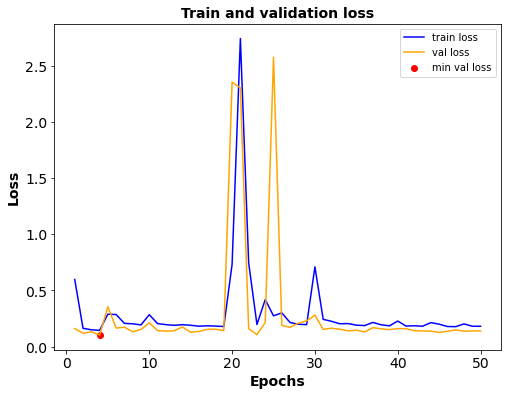

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1,len(train_loss)+1),train_loss,color='b',label='train loss')
plt.plot(np.arange(1,len(val_loss)+1),val_loss,color='orange',label='val loss')
plt.scatter(np.argmin(val_loss)+1,min(val_loss),color='r',label='min val loss')
plt.xlabel('Epochs',size=14,fontweight='bold')
plt.ylabel('Loss',size=14,fontweight='bold')
plt.title('Train and validation loss',size=14,fontweight='bold')
plt.legend()
plt.tick_params(labelsize=14)
plt.savefig('./mnist_train_val_loss.png')
plt.show()

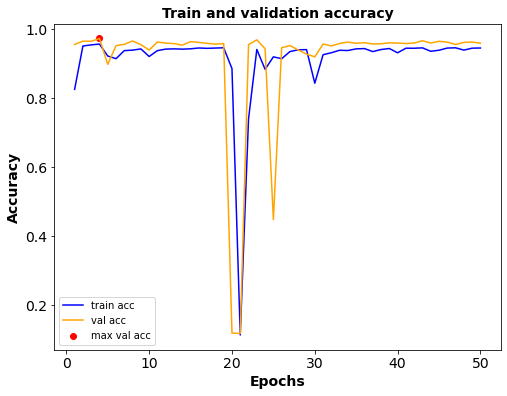

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1,len(train_acc)+1),train_acc,color='b',label='train acc')
plt.plot(np.arange(1,len(val_acc)+1),val_acc,color='orange',label='val acc')
plt.scatter(np.argmax(val_acc)+1,max(val_acc),color='r',label='max val acc')
plt.xlabel('Epochs',size=14,fontweight='bold')
plt.ylabel('Accuracy',size=14,fontweight='bold')
plt.title('Train and validation accuracy',size=14,fontweight='bold')
plt.legend()
plt.tick_params(labelsize=14)
plt.savefig('./mnist_train_val_acc.png')
plt.show()

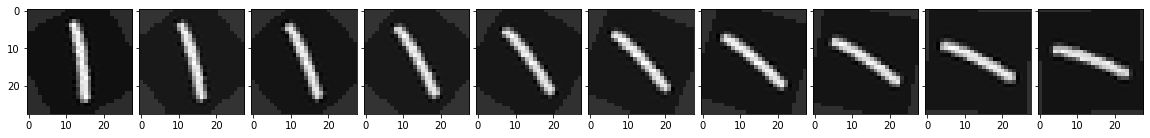

In [ ]:
X_test_batch, y_test_batch = iter(test_dataloader).next()
X_test_batch = X_test_batch.numpy()
X1 = np.array([rotate(X_test_batch[y_test_batch == 1][4].squeeze(), i, reshape=False) for i in range(30, 100, 7)])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

fig = plt.figure(figsize=(20., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, X1):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.reshape((28,28)),cmap='gray')
plt.savefig('./mnist_ones.png')
plt.show()
# for i in range(len(X1)):
#     plt.subplot(gs[i])
#     plt.imshow(X1.squeeze()[i], cmap='gray');
#     plt.axis('off');
# plt.show()

In [ ]:
lit.load_state_dict(torch.load(best_model_path)['state_dict'])
model = lit.backbone
model.eval()

LeNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (drop1): Dropout(p=0.102332158511991, inplace=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (drop2): Dropout(p=0.102332158511991, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=1568, out_features=256, bias=True)
  (drop3): Dropout(p=0.102332158511991, inplace=False)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
out = torch.max(model(torch.from_numpy(X1).float()),1)

/content/drive/My Drive/mcdropout_msc/nns.py:49: UserWarning:

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



In [ ]:
out[1].numpy()

array([1, 1, 1, 1, 3, 3, 7, 7, 7, 7])

In [ ]:
out_mc = predict_mc(model=model,x=torch.from_numpy(X1).float(),mc_samples=500)

/content/drive/My Drive/mcdropout_msc/nns.py:49: UserWarning:

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



In [ ]:
yi_so = np.empty((out_mc.shape[0],10,10))
for i in range(len(out_mc)):
  yi_so[i] = out_mc[i].detach().numpy()

In [ ]:
yi_so = np.exp(yi_so)

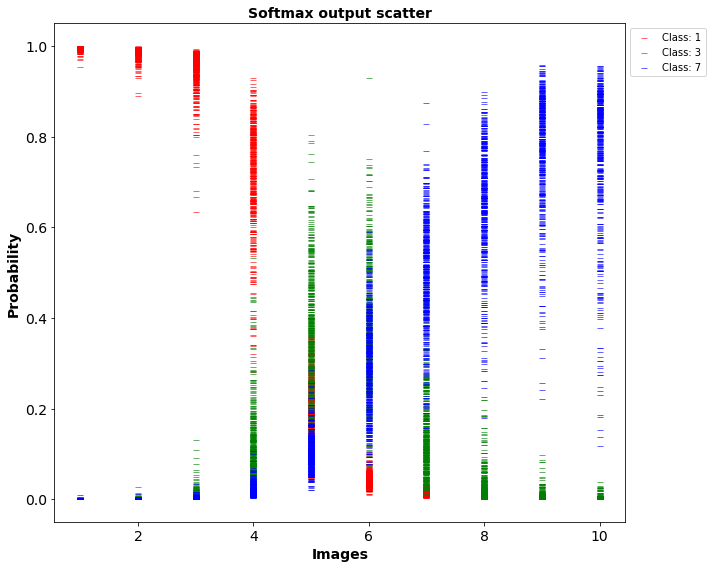

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(np.tile(np.arange(1, 11), out_mc.shape[0]), yi_so[:, :, 1].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.6, label='Class: 1')
plt.scatter(np.tile(np.arange(1, 11), out_mc.shape[0]), yi_so[:, :, 3].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.6, label='Class: 3')
plt.scatter(np.tile(np.arange(1, 11), out_mc.shape[0]), yi_so[:, :, 7].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.6, label='Class: 7')
plt.title('Softmax output scatter',size=14,fontweight='bold')
plt.xlabel('Images',size=14,fontweight='bold')
plt.ylabel('Probability',size=14,fontweight='bold')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('./softmax_ones.png')
plt.show()

**Evaluate on test set**

In [ ]:
X_test_np = test.dataset.data.numpy()[test.indices]
y_test_np = test.dataset.train_labels.numpy()[test.indices]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning:

train_labels has been renamed targets



In [ ]:
X_test_np = X_test_np.reshape((X_test_np.shape[0],1,28,28))

In [ ]:
preds = torch.max(model(torch.from_numpy(X_test_np).float()),1)

/content/drive/My Drive/mcdropout_msc/nns.py:49: UserWarning:

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



In [ ]:
accuracy_score(y_test_np,preds.indices.numpy())

0.9452

In [ ]:
fx_1 = yi_so[:,0,:]
fx_2 = yi_so[:,1,:]
fx_3 = yi_so[:,2,:]
fx_4 = yi_so[:,3,:]
fx_5 = yi_so[:,4,:]
fx_6 = yi_so[:,5,:]
fx_7 = yi_so[:,6,:]
fx_8 = yi_so[:,7,:]
fx_9 = yi_so[:,8,:]
fx_10 = yi_so[:,9,:]

Compute variation ratio

In [ ]:
ffs1 = np.apply_along_axis(lambda x:np.argmax(x),axis=1,arr= fx_10)
1 - (len(ffs1[ffs1 == 7])/500)

0.07199999999999995

Compute Entropy

In [ ]:
p=np.sum(fx_5,axis=0)/500

In [ ]:
p

array([4.16845132e-04, 1.15345292e-02, 2.89212834e-01, 1.43080146e-01,
       1.95637961e-02, 9.93769207e-03, 1.08791480e-03, 4.96958630e-01,
       2.79336981e-02, 2.73916156e-04])

In [ ]:
entropy(p,base=2)

2.549252614528147

In [ ]:
0